<font size="5"><center> **Exercise 3 <br>
(Implementation of Conditional VAE)** </center></font>
<font size="4"><center> CS-673 <br> Introduction to Deep Generative Models </center></font>
<font size="4"><center> Sifakis Emmanouil, *1288* </center></font>

---

↓ Imports ↓

In [35]:
# # Comment the following lines if you're not in colab:
# from google.colab import drive
# drive.mount('/content/drive')
# # If you're in colab, cd to your own working directory here:
# %cd ..//..//content//drive//MyDrive//Colab-Notebooks//HY-673-Tutorials//Tutorial-8

In [36]:
import torch as tc
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import MNIST
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchsummary import summary

import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import os

seed = 42
tc.manual_seed(seed)
device = 'cuda' if tc.cuda.is_available() else 'cpu'
print(f"using {device}")

using cuda


→ (b): Using a (stochastic) decoder with input $(z, y)$ and a (stochastic) encoder with input $(x, y)$, implement the conditional VAE for MNIST digit generation.
    

<font size = '3'> Below is a brief explanation of the main components and the important changes made to adapt a traditional VAE (that was provided by the Tutorial 8 of the course) network into a conditional VAE (CVAE).

↓ Conditional Encoder - Decoder ↓

<font size='3'> In the <u>original VAE</u>, the encoder maps the input image to a latent space.<br>
In the case of <u>Conditional VAE</u>, the encoder takes both the input image and a one-hot encoded label, concatenating them before mapping to the latent space, ensuring the representation is conditioned on the label.

In [37]:
class FCEncoder(nn.Module):
    def __init__(self, input_dim:int, num_labels:int, latent_dim:int=64):
        super(FCEncoder, self).__init__()

        self.input_dim = input_dim  # 28*28 = 784 for MNIST
        self.latent_dim = latent_dim
        self.num_labels = num_labels # extra input for condition
        # first to last layers:
        self.fc1 = nn.Linear(in_features=input_dim + num_labels, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=256)
        self.fc3 = nn.Linear(in_features=256, out_features=latent_dim * 2)
        # activations:
        self.prelu1 = nn.PReLU()
        self.prelu2 = nn.PReLU()

    def forward(self, x, y):
        # reshape input image (x)
        x = x.view(-1, self.input_dim)
        # reshape one-hot encoded label (y)
        y = y.view(-1, self.num_labels)
        # concatenate image and label
        x = tc.cat((x, y), dim=1)
        x = self.prelu1(self.fc1(x))
        x = self.prelu2(self.fc2(x))
        x = self.fc3(x)
        # half of the latent values are used for the mean, half for the log-variance:
        mu = x[:, :self.latent_dim]
        logvar = x[:, self.latent_dim:]
        return mu, logvar

class FCDecoder(nn.Module):
    def __init__(self, input_dim:int, num_labels:int, latent_dim:int=64):
        super(FCDecoder, self).__init__()

        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.num_labels = num_labels
        # first to last layers:
        self.rev_fc3 = nn.Linear(in_features=self.latent_dim + num_labels, out_features=256)
        self.rev_fc2 = nn.Linear(in_features=256, out_features=512)
        self.rev_fc1 = nn.Linear(in_features=512, out_features=self.input_dim)
        # activations:
        self.prelu3 = nn.PReLU()
        self.prelu2 = nn.PReLU()

    def forward(self, z, y):
        # reshape latent vector (z)
        z = z.view(-1, self.latent_dim)
        # reshape one-hot encoded label (y)
        y = y.view(-1, self.num_labels)
        # concatenate latent vector and label
        z = tc.cat((z, y), dim=1)
        x = self.prelu3(self.rev_fc3(z))
        x = self.prelu2(self.rev_fc2(x))
        x = tc.sigmoid(self.rev_fc1(x))
        return x

↓ Conditional FCVAE ↓

The conditional FCVAE class extends the traditional VAE by conditioning on labels. This is achieved by concatenating the one-hot encoded labels with the input images and latent vectors in the encoder and decoder, respectively. This allows the model to generate images conditioned on specific labels, enabling controlled image generation.

In [38]:
class FCVAE(nn.Module):

    def __init__(self, inpt_shape:tuple=(1, 28, 28), num_labels:int=10, latent_dim:int=64):
        super(FCVAE, self).__init__()

        self.input_shape = inpt_shape
        self.input_dim = np.prod(inpt_shape)
        self.latent_dim = latent_dim
        self.num_labels = num_labels

        self.encoder = FCEncoder(input_dim=self.input_dim, num_labels=self.num_labels, 
                                 latent_dim=self.latent_dim)
        self.decoder = FCDecoder(input_dim=self.input_dim, num_labels=self.num_labels, 
                                 latent_dim=self.latent_dim)

    def forward(self, x, y):
        x = x.view(-1, self.input_dim)
        # pass through encoder to compress input to latent space:
        mu, logvar = self.encoder(x, y)
        # get z by scaling with std and adding the mean:
        z = self.reparametrize(mu, logvar)
        # pass through decoder to get a reconstruction of the input:
        x_hat = self.decoder(z, y).view(-1, *self.input_shape)
        return x_hat, mu, logvar, z

    def sample(self, n: int, y):
        z = tc.randn(size=(n, self.latent_dim), device=device)
        y = y.view(-1, self.num_labels)
        return self.decoder(z, y).view(-1, *self.input_shape)

    @staticmethod
    def reparametrize(mu, logvar):
        # 0.5 because variance is the square root
        # of the standard deviation:
        std = tc.exp(0.5 * logvar)
        z = tc.randn_like(std)
        return std * z + mu

↓ Dequantize and Scale images ↓

In [39]:
# add uniform noise to dequantize images and scales them to a specified range, 
# clamping the values between 0 and 1.
class DequantizeAndScale(tc.nn.Module):
    def __init__(self, scale_range=(0, 1)):
        super().__init__()
        self.min_val, self.max_val = scale_range

    def forward(self, img):
        img += tc.rand_like(img) / 256.0
        img *= (self.max_val - self.min_val) + self.min_val
        return img.clamp(0, 1)

In [40]:
# Generates and visualizes samples from the trained model conditioned on labels
def sample_model(model, n_samples=10, title="None"):
    # Model sampling happens here:
    y_sample = tc.eye(10).to(device)
    x_hat = model.sample(n_samples, y_sample)
    x_hat = x_hat.cpu().detach().numpy().reshape(n_samples, 28, 28)
    # The rest is just plotting:
    fig, axs = plt.subplots(
        nrows=2,
        ncols=5,
        figsize=(10, 4),
        subplot_kw={'xticks': [], 'yticks': [], 'frame_on': False}
    )
    for i, axis in enumerate(axs.flat):
        axis.imshow(x_hat[i], cmap='binary')
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    fig.suptitle(title, fontsize=16)
    plt.show()
    plt.close()

↓ Loss Function ↓

The loss_fn function computes the loss for training the Conditional VAE. It combines the reconstruction loss and the KL divergence, which are the two main components of the VAE loss function.

In [41]:
def loss_fn(x, x_hat, logvar, mu, beta=1):
    # Reconstruction loss:
    bce = F.binary_cross_entropy(input=x_hat, target=x)
    # KLD between Gaussian r.v.s:
    kld = -0.5 * tc.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return bce, beta * kld

↓ Train the Conditional VAE model ↓

In [50]:
def train_loop(model, num_labels, epochs, train_loader, lr,
               checkpoint_folder = 'checkpoints',checkpoint_name = 'best_cVAE.pth'):

    os.makedirs(checkpoint_folder, exist_ok=True)
    checkpoint_path = os.path.join(checkpoint_folder, checkpoint_name)

    beta = 1
    print_every = 5
    optimizer = optim.Adam(model.parameters(), lr)

    losses_bce = tc.zeros(epochs, device=device)
    losses_kld = tc.zeros(epochs, device=device)
    best_loss = 100

    model.train()
    for epoch in range(epochs):
        bce_loss = 0
        kld_loss = 0
        for x, y in tqdm(train_loader):
            # zero gradients:
            optimizer.zero_grad()
            # put batch to device:
            x = x.to(device)
            y = F.one_hot(y, num_labels).float().to(device)
            # call model:
            x_hat, mu, logvar, z = model(x, y)
            # compute loss:
            bce, kld = loss_fn(x=x, x_hat=x_hat, logvar=logvar, mu=mu, beta=beta)
            # backpropagation:
            (bce + kld).backward()
            # update weights:
            optimizer.step()
            # save losses:
            bce_loss += bce.item()
            kld_loss += kld.item()

        # print, save & evaluate:
        bce_loss /= len(train_loader)
        kld_loss /= len(train_loader)
        print(f"Epoch {epoch + 1}/10 | BCE = {bce_loss:.4f} | KLD = {kld_loss:.4f}")
        losses_bce[epoch] = bce_loss
        losses_kld[epoch] = kld_loss
        if (epoch + 1) % print_every == 0:
            model.eval()
            sample_model(model, n_samples=10,title=f"Epoch {epoch + 1}")
            model.train()
        if bce_loss + kld_loss < best_loss:
            best_loss = bce_loss + kld_loss
            tc.save(model.state_dict(), checkpoint_path)

    # return bce_loss, kld_loss
    return losses_bce, losses_kld

↓ Main ↓

100%|██████████| 469/469 [00:09<00:00, 48.48it/s]


Epoch 1/10 | BCE = 0.2505 | KLD = 0.0021


100%|██████████| 469/469 [00:07<00:00, 60.78it/s]


Epoch 2/10 | BCE = 0.2231 | KLD = 0.0053


100%|██████████| 469/469 [00:07<00:00, 62.64it/s]


Epoch 3/10 | BCE = 0.2115 | KLD = 0.0109


100%|██████████| 469/469 [00:11<00:00, 42.63it/s]


Epoch 4/10 | BCE = 0.2054 | KLD = 0.0137


100%|██████████| 469/469 [00:16<00:00, 28.76it/s]


Epoch 5/10 | BCE = 0.2033 | KLD = 0.0148


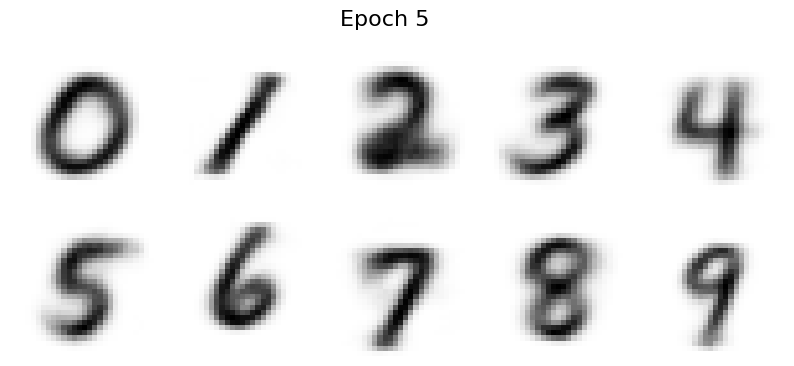

100%|██████████| 469/469 [00:16<00:00, 28.80it/s]


Epoch 6/10 | BCE = 0.2019 | KLD = 0.0154


100%|██████████| 469/469 [00:14<00:00, 32.19it/s]


Epoch 7/10 | BCE = 0.2009 | KLD = 0.0161


100%|██████████| 469/469 [00:09<00:00, 49.75it/s]


Epoch 8/10 | BCE = 0.1990 | KLD = 0.0172


100%|██████████| 469/469 [00:16<00:00, 28.21it/s]


Epoch 9/10 | BCE = 0.1971 | KLD = 0.0185


100%|██████████| 469/469 [00:16<00:00, 27.96it/s]


Epoch 10/10 | BCE = 0.1960 | KLD = 0.0192


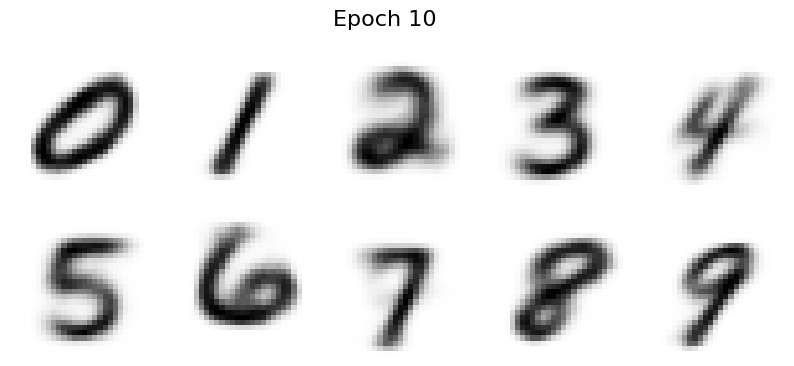

100%|██████████| 469/469 [00:17<00:00, 27.31it/s]


Epoch 11/10 | BCE = 0.1951 | KLD = 0.0196


100%|██████████| 469/469 [00:14<00:00, 32.11it/s]


Epoch 12/10 | BCE = 0.1945 | KLD = 0.0201


100%|██████████| 469/469 [00:09<00:00, 52.06it/s]


Epoch 13/10 | BCE = 0.1939 | KLD = 0.0203


100%|██████████| 469/469 [00:11<00:00, 41.37it/s]


Epoch 14/10 | BCE = 0.1935 | KLD = 0.0207


100%|██████████| 469/469 [00:17<00:00, 26.53it/s]


Epoch 15/10 | BCE = 0.1931 | KLD = 0.0209


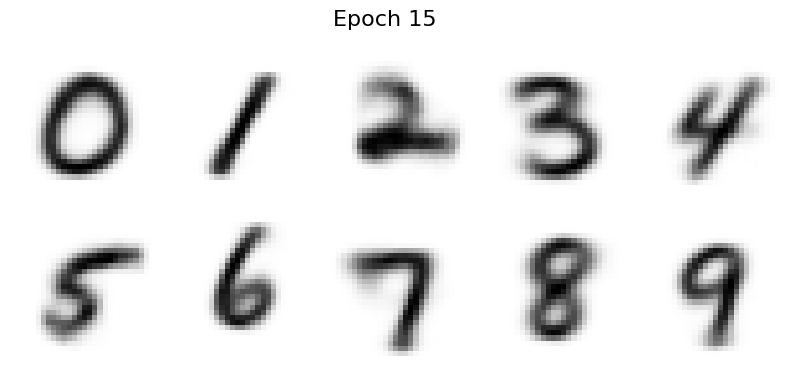

100%|██████████| 469/469 [00:17<00:00, 26.28it/s]


Epoch 16/10 | BCE = 0.1928 | KLD = 0.0211


100%|██████████| 469/469 [00:18<00:00, 26.04it/s]


Epoch 17/10 | BCE = 0.1925 | KLD = 0.0212


100%|██████████| 469/469 [00:17<00:00, 26.26it/s]


Epoch 18/10 | BCE = 0.1922 | KLD = 0.0214


100%|██████████| 469/469 [00:17<00:00, 26.21it/s]


Epoch 19/10 | BCE = 0.1921 | KLD = 0.0216


100%|██████████| 469/469 [00:15<00:00, 30.30it/s]


Epoch 20/10 | BCE = 0.1917 | KLD = 0.0217


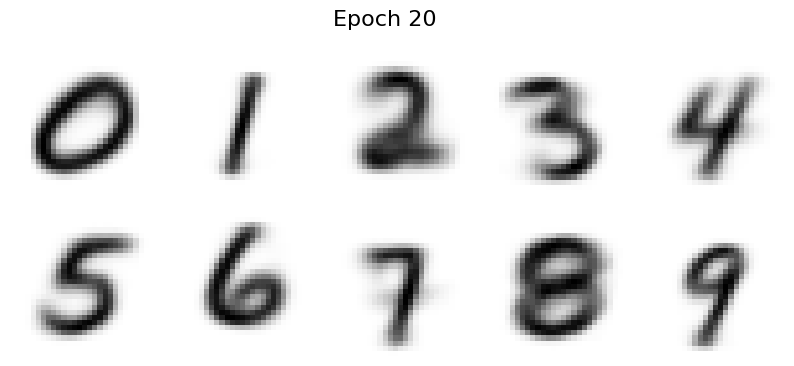

100%|██████████| 469/469 [00:09<00:00, 51.62it/s]


Epoch 21/10 | BCE = 0.1915 | KLD = 0.0218


100%|██████████| 469/469 [00:06<00:00, 68.77it/s]


Epoch 22/10 | BCE = 0.1915 | KLD = 0.0217


100%|██████████| 469/469 [00:07<00:00, 58.80it/s]


Epoch 23/10 | BCE = 0.1912 | KLD = 0.0220


100%|██████████| 469/469 [00:15<00:00, 29.37it/s]


Epoch 24/10 | BCE = 0.1910 | KLD = 0.0222


100%|██████████| 469/469 [00:17<00:00, 26.99it/s]


Epoch 25/10 | BCE = 0.1910 | KLD = 0.0221


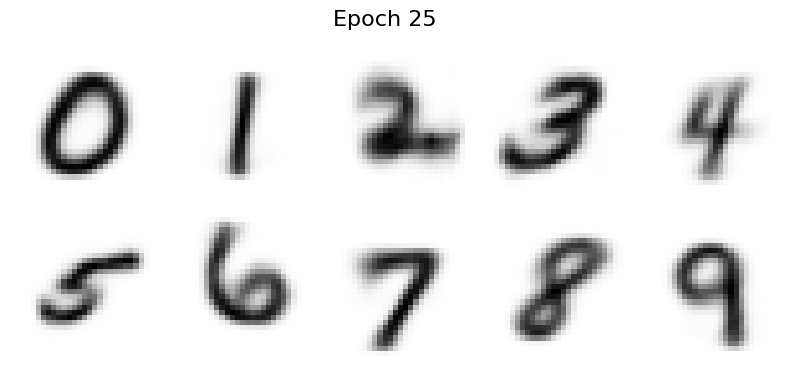

100%|██████████| 469/469 [00:17<00:00, 26.46it/s]


Epoch 26/10 | BCE = 0.1908 | KLD = 0.0221


100%|██████████| 469/469 [00:08<00:00, 53.82it/s]


Epoch 27/10 | BCE = 0.1908 | KLD = 0.0221


100%|██████████| 469/469 [00:07<00:00, 60.66it/s]


Epoch 28/10 | BCE = 0.1906 | KLD = 0.0222


100%|██████████| 469/469 [00:07<00:00, 58.89it/s]


Epoch 29/10 | BCE = 0.1905 | KLD = 0.0223


100%|██████████| 469/469 [00:08<00:00, 56.22it/s]


Epoch 30/10 | BCE = 0.1905 | KLD = 0.0224


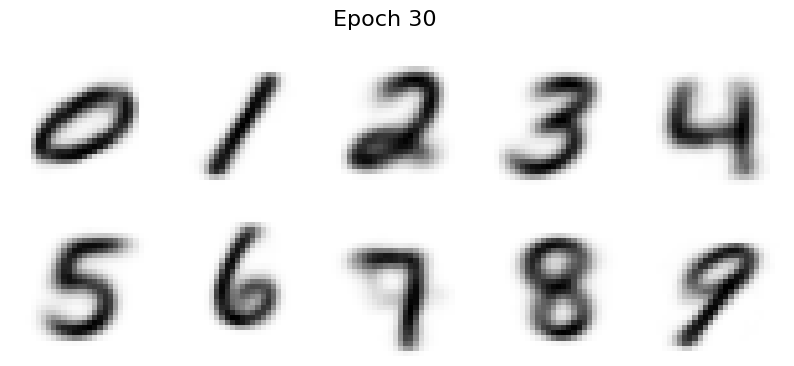

100%|██████████| 469/469 [00:09<00:00, 50.42it/s]


Epoch 31/10 | BCE = 0.1904 | KLD = 0.0224


100%|██████████| 469/469 [00:07<00:00, 59.91it/s]


Epoch 32/10 | BCE = 0.1902 | KLD = 0.0225


100%|██████████| 469/469 [00:08<00:00, 54.69it/s]


Epoch 33/10 | BCE = 0.1902 | KLD = 0.0225


100%|██████████| 469/469 [00:08<00:00, 53.42it/s]


Epoch 34/10 | BCE = 0.1901 | KLD = 0.0227


100%|██████████| 469/469 [00:19<00:00, 23.95it/s]


Epoch 35/10 | BCE = 0.1901 | KLD = 0.0226


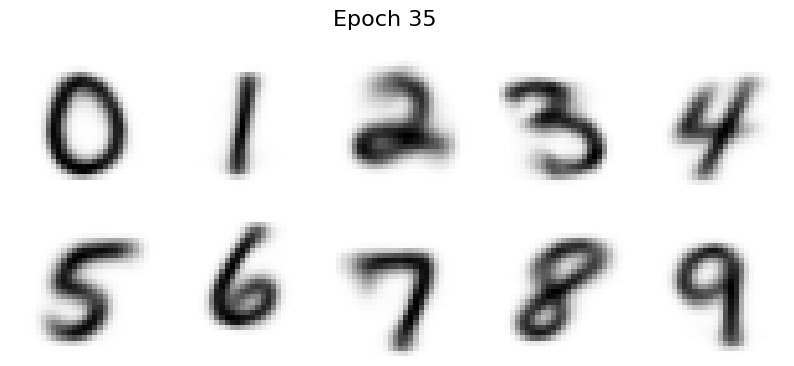

100%|██████████| 469/469 [00:19<00:00, 24.00it/s]


Epoch 36/10 | BCE = 0.1899 | KLD = 0.0229


100%|██████████| 469/469 [00:17<00:00, 26.63it/s]


Epoch 37/10 | BCE = 0.1898 | KLD = 0.0228


100%|██████████| 469/469 [00:18<00:00, 25.33it/s]


Epoch 38/10 | BCE = 0.1898 | KLD = 0.0227


100%|██████████| 469/469 [00:19<00:00, 24.48it/s]


Epoch 39/10 | BCE = 0.1898 | KLD = 0.0228


100%|██████████| 469/469 [00:18<00:00, 26.03it/s]


Epoch 40/10 | BCE = 0.1898 | KLD = 0.0229


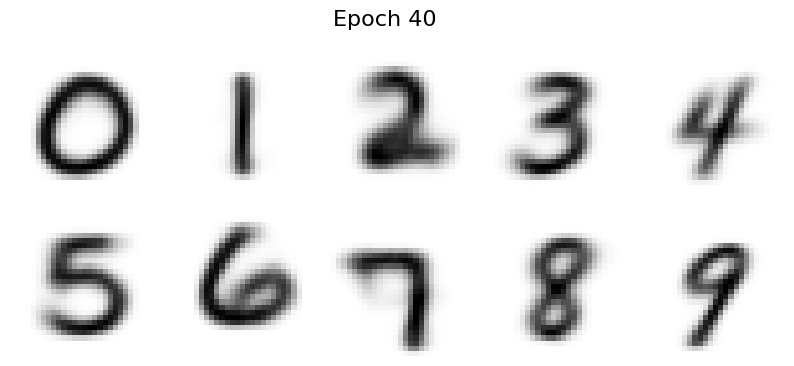

100%|██████████| 469/469 [00:18<00:00, 25.17it/s]


Epoch 41/10 | BCE = 0.1896 | KLD = 0.0229


100%|██████████| 469/469 [00:17<00:00, 26.80it/s]


Epoch 42/10 | BCE = 0.1895 | KLD = 0.0230


100%|██████████| 469/469 [00:18<00:00, 25.88it/s]


Epoch 43/10 | BCE = 0.1894 | KLD = 0.0230


100%|██████████| 469/469 [00:17<00:00, 27.12it/s]


Epoch 44/10 | BCE = 0.1895 | KLD = 0.0230


100%|██████████| 469/469 [00:11<00:00, 40.72it/s]


Epoch 45/10 | BCE = 0.1894 | KLD = 0.0231


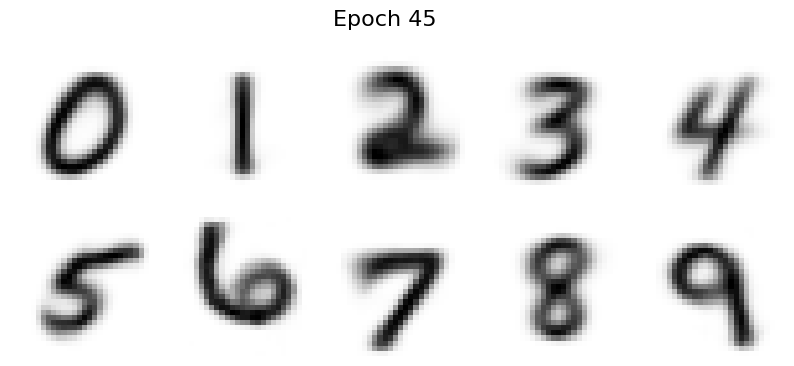

100%|██████████| 469/469 [00:18<00:00, 25.53it/s]


Epoch 46/10 | BCE = 0.1894 | KLD = 0.0230


100%|██████████| 469/469 [00:18<00:00, 24.94it/s]


Epoch 47/10 | BCE = 0.1893 | KLD = 0.0231


100%|██████████| 469/469 [00:18<00:00, 26.02it/s]


Epoch 48/10 | BCE = 0.1894 | KLD = 0.0230


100%|██████████| 469/469 [00:18<00:00, 25.26it/s]


Epoch 49/10 | BCE = 0.1893 | KLD = 0.0231


100%|██████████| 469/469 [00:18<00:00, 25.28it/s]


Epoch 50/10 | BCE = 0.1892 | KLD = 0.0233


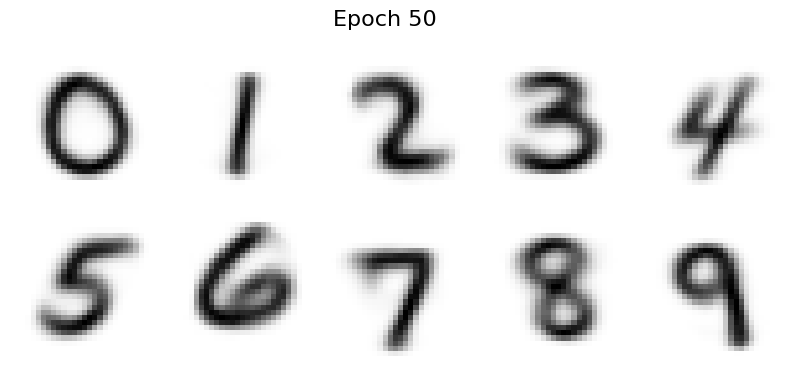

100%|██████████| 469/469 [00:18<00:00, 25.38it/s]


Epoch 51/10 | BCE = 0.1891 | KLD = 0.0231


100%|██████████| 469/469 [00:18<00:00, 25.28it/s]


Epoch 52/10 | BCE = 0.1891 | KLD = 0.0231


100%|██████████| 469/469 [00:17<00:00, 26.39it/s]


Epoch 53/10 | BCE = 0.1891 | KLD = 0.0231


100%|██████████| 469/469 [00:18<00:00, 25.71it/s]


Epoch 54/10 | BCE = 0.1891 | KLD = 0.0232


100%|██████████| 469/469 [00:18<00:00, 25.57it/s]


Epoch 55/10 | BCE = 0.1889 | KLD = 0.0233


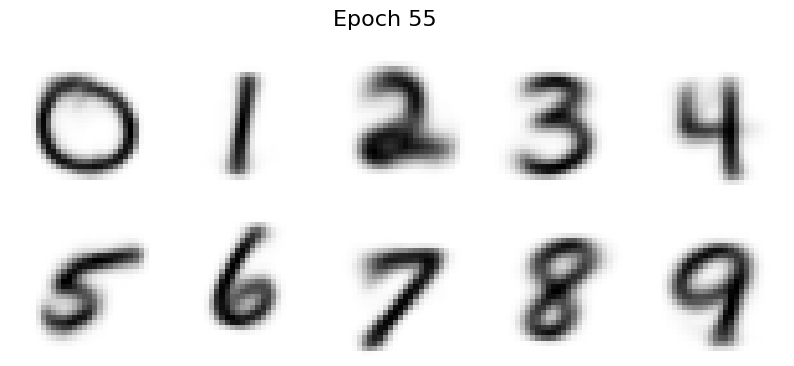

100%|██████████| 469/469 [00:17<00:00, 26.33it/s]


Epoch 56/10 | BCE = 0.1889 | KLD = 0.0233


100%|██████████| 469/469 [00:17<00:00, 26.25it/s]


Epoch 57/10 | BCE = 0.1888 | KLD = 0.0232


100%|██████████| 469/469 [00:18<00:00, 25.47it/s]


Epoch 58/10 | BCE = 0.1888 | KLD = 0.0235


100%|██████████| 469/469 [00:16<00:00, 28.87it/s]


Epoch 59/10 | BCE = 0.1888 | KLD = 0.0234


100%|██████████| 469/469 [00:10<00:00, 44.33it/s]


Epoch 60/10 | BCE = 0.1887 | KLD = 0.0234


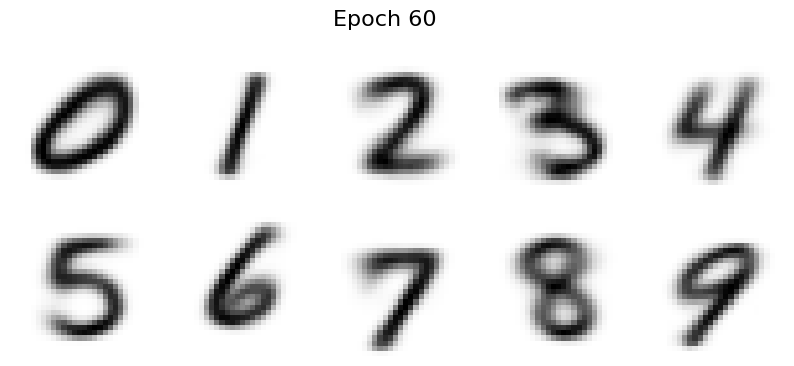

In [48]:
length, height = 28, 28  # MNIST is 28*28 images
input_shape = (1, height, length)
latent_dim_ = 64
num_labels = 10

batch_size = 128
epochs = 60
lr = 1e-3

# Load the MNIST dataset
transform_pipeline = transforms.Compose([transforms.ToTensor(),DequantizeAndScale()])
train_dataset = MNIST(root='./data', train=True, download=True, transform=transform_pipeline)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# model = FCVAE(inpt_shape=(1, 28, 28), num_labels=10, latent_dim=64).to(device)
model = FCVAE(inpt_shape=input_shape, num_labels=num_labels, latent_dim=latent_dim_).to(device)
bces, klds = train_loop(model, num_labels, epochs, train_loader, lr,
                        checkpoint_name = 'best_cVAE.pth')

# The results below for 60 epochs may be collapsed


↓ Loss Plots ↓

Plots the BCE and KLD loss and their sum over the training epochs. 

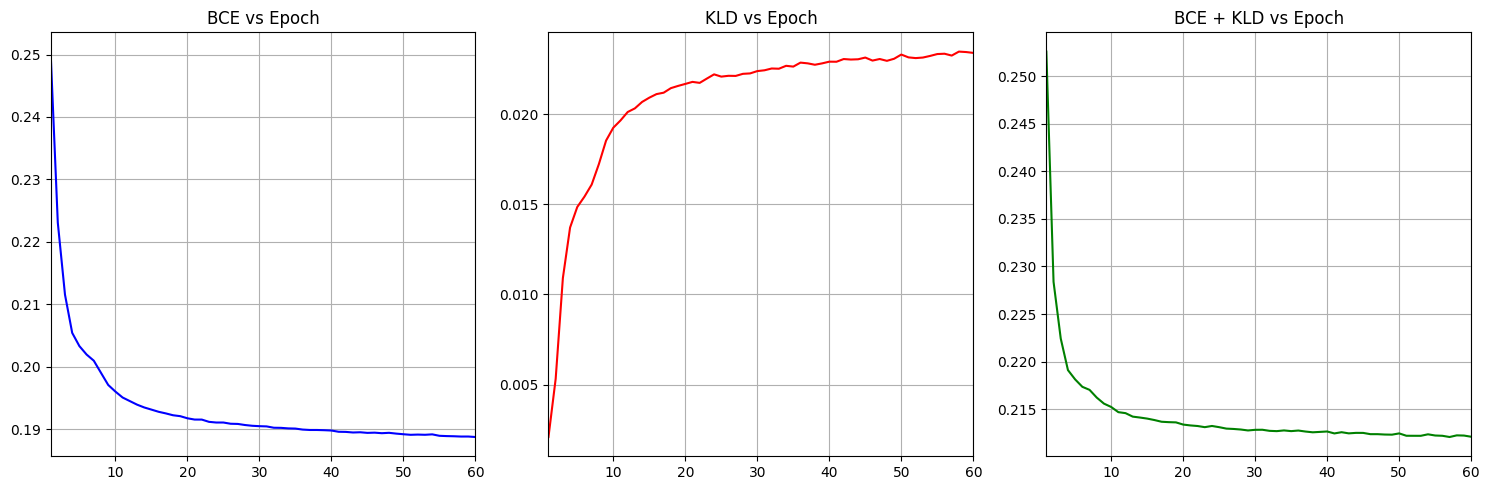

In [49]:
bces = bces.cpu().numpy()
klds = klds.cpu().numpy()
epoch_ax = np.arange(start=1, stop=epochs+1, step=1)
_, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].plot(epoch_ax, bces, color='blue')
ax[0].set_xlim(1, epochs)
ax[0].set_title("BCE vs Epoch")
ax[0].grid()

ax[1].plot(epoch_ax, klds, color='red')
ax[1].set_xlim(1, epochs)
ax[1].set_title("KLD vs Epoch")
ax[1].grid()

ax[2].plot(epoch_ax, bces + klds, color='green')
ax[2].set_xlim(1, epochs)
ax[2].set_title("BCE + KLD vs Epoch")
ax[2].grid()

plt.tight_layout()
plt.show()
plt.close()

→ (c): Using the trained VAE to generate images conditioned on input labels, returning images for each digit specified in an input array, and to provide examples of the generated images with their corresponding labels.

Below after the loading of the previous trained on 60 epochs model I am generating images based on input labels, and plotting these images. It is able to handle both single and multiple labels.

In [45]:
def generate_images(labels, model):
    # Convert the labels to one-hot encoding
    labels_tensor = F.one_hot(tc.tensor(labels), num_classes=10).float().to(device)
    # Generate images using the model
    generated_images = model.sample(n=len(labels), y=labels_tensor)
    return generated_images

def plot_generated_images(images, labels):
    n = len(labels)
    fig, axs = plt.subplots(1, n, figsize=(n*2, 2), subplot_kw={'xticks': [], 'yticks': [], 'frame_on': False})
    for i, ax in enumerate(axs if n > 1 else [axs]):
        ax.imshow(images[i], cmap='binary')
        ax.set_title(f'Label: {labels[i]}')
    plt.show()

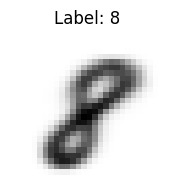

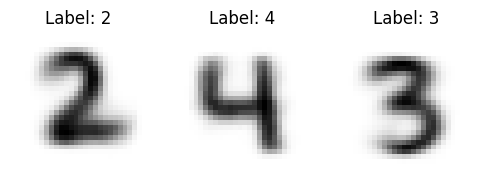

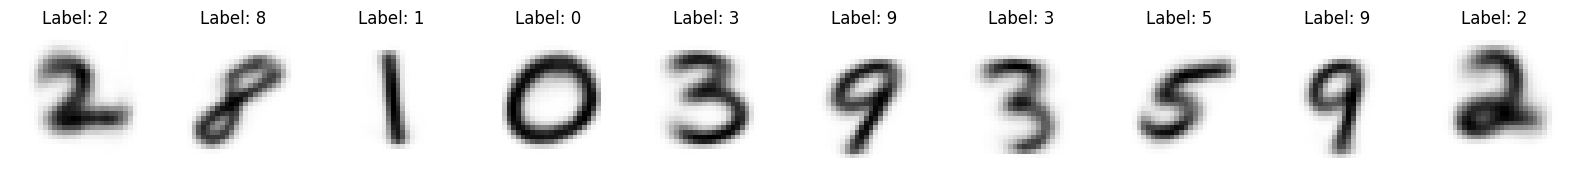

In [51]:
checkpoint_path = 'checkpoints/best_vae.pth'
model.load_state_dict(tc.load(checkpoint_path))
model.eval()

# Single label (8)
input_labels = [8]
generated_images = generate_images(input_labels, model)
generated_images_np = generated_images.cpu().detach().numpy().reshape(len(input_labels), 28, 28)
plot_generated_images(generated_images_np, input_labels)

# Multiple labels (2,4,3)
input_labels = [2,4,3]
generated_images = generate_images(input_labels, model)
generated_images_np = generated_images.cpu().detach().numpy().reshape(len(input_labels), 28, 28)
plot_generated_images(generated_images_np, input_labels)

# Even More (2810393592) -> Postgraduate studies secretariat Number
input_labels = [2,8,1,0,3,9,3,5,9,2]
generated_images = generate_images(input_labels, model)
generated_images_np = generated_images.cpu().detach().numpy().reshape(len(input_labels), 28, 28)
plot_generated_images(generated_images_np, input_labels)

